# Generating Embeddings for Protein Clustering

In this example we will use the BioNeMo Framework to show how to
* Load and work with data
* Load a pretrained model 
* Extract embeddings
* Build simple vizualisations
* Perform a Clustering task with the embeddings


## Prerequisites:
- BioNeMo Framework container is running (refer to the [Quickstart Guide](../quickstart-fw.md))
- Familiarity with some components of the BioNeMo framework such as the [Models](../models/esm2nv.md) and [Inferencing](../inference-grpc-fw.md)

## Download the Pre-trained Models

The basic building blocks are already implemented in the BioNeMo Framework. It comes with a set of scripts that make it easier to download pre-trained models from NVIDIA NGC. 

As of the pre-release version (13 JUN 2023), we have the following models available:

- Molecule/MegaMolBART
- Protein/ESM-1nv
- Protein/ESM-2nv: 650M and 3B variants.
- Protein/ProtT5nv

Once the container has been succesfully pulled and the `.env` file configured correctly, **download the pre-trained models** with 

`bash launch.sh download`

The command above will invoke a routine that downloads the models from published addresses such as in `/bionemo/ci/blossom/download_all_models.sh`.

For example, we can see MegaMolBart being download from `https://api.ngc.nvidia.com/v2/models/nvidia/clara/megamolbart_0_2/versions/0.2.0/zip`. 

Once execution is complete, you will see files with the `.nemo` extension within the folder specified in the `MODEL_PATH=${MODEL_PATH:=${PROJECT_PATH}/<DIRECTORY>}` configuration of your `.env` file. 

Refer to the [Quickstart Guide](../quickstart-fw.md) for more info about the `.env` file.

## Run the container

`docker run -it -p 8888:8888 --gpus all -v <model directory>:<mount destination> <BioNeMo_Image> <model>`

_This example has been built upon a contaier running in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multinode launch](../inference-grpc-fw.md)._

The comman above will set up a 'Jupyter Lab' that can be found on `localhost:8888` 


> **.nemo Files**   
> Make sure the models downloaded are within the desired project mount directory such as `/models/protein/esm2nv`; otherwise, you may have to move the `.nemo` files, such as `esm2nv_650M_converted.nemo` from wherever it has been downloaded into.    

> **Jupyter Lab's Workspace**   
> If you type `pwd` in the Jupyter Lab's terminal, this may not show BioNeMo's original directory in your machine but yet another directory such as `/workspace`, according to the project mount directory you've set in the `.env` file. 


In this example, we will be working with the [ESM2-nv model](../models/esm2-nv.md), the UniRef50 and the UniProtKB Dataset by UniProt.org. 

ESM-2nv was developed using the BioNeMo framework. The model uses an architecture called Bidirectional Encoder Representations from Transformers (BERT) and is based on the ESM-2 model 

You may want to run the code as provided in the cells below - into a Jupyter Notebook launched from the JupyterLab interface running inside the container.


Before running the code below, ensure that you have launched a gRPC client with the ESM2nv-650M model using the following command
```bash
python3 -m bionemo.model.protein.esm1nv.grpc.service --model esm2nv_650M
```

## Download the data

The Universal Protein Resource (UniProt) is a comprehensive resource for protein sequence and annotation data [[1]](https://www.uniprot.org/help/about). The UniRef is a set of Reference Clusters with sequences from the UniProt Knowledge base and selected UniParc records. UniRef50 is a "second derivation" of UniRef100: Uniref90 is generated by clustering UniRef100 seed sequences and UniRef50 is generated by clustering UniRef90 sequences. For more information, refer to the [UniRef](https://www.uniprot.org/help/uniref) page.


### Using BioNeMo features to download UniRef50

The simplest and most reliable way to download the _entire_ UniRef50 dataset is through the BioNeMo framework `UniRef50Preprocess` class which has the following features:

- Runs a _fasta_ indexer
- Splits the data into train, validation and test sets
- Writes the dataset in the appropriate directories within the BioNeMo Framework `/tmp/uniref50/processed`


For example,

```python
from bionemo.data import UniRef50Preprocess
data = UniRef50Preprocess()
data.prepare_dataset()
```

**Note** that we use `UniRef50Preprocess`, instead of `ESM2Preprocess` class as in this notebook we focus on the inference step and how to cluster ESM2 pre-trained embeddings 
for analysis. For more information about pre-training data preparation using `ESM2Preprocess`, please refer to the [pre-training notebook](./model_training_esm2nv.ipynb)


### Alternative datasets 
We can also download datasets that are not available in the BioNeMo Framework. This can be done in two ways:

**A) Using bash and wget pointing to the dataset's URL**

```bash
mkdir -p /tmp/data/protein/esm2nv  
wget -P /tmp/data/protein/esm2nv <URL>
```

**B) Transfering from the local machine to the container**

```bash
docker cp <dataset directory and filename> container_id:/<container directory and filename>
```

## Generating Embeddings

The BioNeMo-way is simple:

```python
# Initalize the Inference Wrapper that will invoke the pre-trained model
esm = ESMInferenceWrapper()
# Work with a set of sequences (these are invalid sequences despite valid amino-acids)
sequence_examples = ["TRANSCENDINGLIMITS", "MASTERMINDING"]
# Generate Embeddings
embeddings = esm.seq_to_embedding(sequence_examples)

# Print the shape of embeddings
print(f"Shape of embeddings (2, 768): {embeddings.shape}")
```

This requires fewer lines of code than, for example, [Rostlab's Example in Hugging Face](https://huggingface.co/Rostlab/prot_t5_xl_uniref50) as the `ESMInferenceWrapper` class takes care of the tokenization process and the hidden states handling

## Example
Since we are now familiar with the basic building blocks of the BioNeMo Framework to generate Protein Embeddings, let's tackle and example including data vizualization and clustering with the UniProtKB Dataset.

To perform this in an efficient manner, we will ustilize open-source CUDA accelarated data science and machiene learning libraries such as cuML, cuDF, cuPY. For more information, check out [NVIDIA RAPIDS](https://rapids.ai/). 

[cuDF](https://github.com/rapidsai/cudf) provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming. Similarly, [cuML](https://github.com/rapidsai/cuml) enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs. In most cases, cuML's Python API matches the API from scikit-learn.

:::{note}
The following cells containing python code snippets can be directly copied and executed into a Python environment such as a Jupyter notebook running in a BioNemo container.
:::

In [1]:
%%time
import numpy as np              # numpy for simple array manipulations
import cudf                     # Using cudf from NVIDIA RAPIDS
import matplotlib.pyplot as plt # Matplotlib for data vizualization
import pandas as pd             # simple dataframe manipulation
import cuml                     # We will use DBSCAN for clustering with unkown labels and clusters
import cupy as cp               # To process arrays on the GPU
import torch                    # To deal with tensors

# bionemo utils
from bionemo.data import UniRef50Preprocess
from infer import ESMInferenceWrapper

# Dimensionality reduction algorithm 
from cuml.manifold import TSNE as cumlTSNE
from sklearn.preprocessing import StandardScaler

NOTE! Installing ujson may make loading annotations faster.
CPU times: user 5.11 s, sys: 8.69 s, total: 13.8 s
Wall time: 9.22 s


> **Internet Speed**
> The step below downloads the UniProtKB Database with 569,516 entries. It can take a while to process depending on your internet connection speeds.

In [2]:
%%time
data = UniRef50Preprocess()     # Instantiate a new UniRef data process
'''
Downloads the UniProtKB Database 
The UniProtKB Dataset has 569,516 entries. 
'''
data.prepare_dataset(url="https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/uniprot_sprot.fasta.gz",
                    num_csv_files=1,
                    val_size=85000,
                    test_size=85000, 
                    source='uniprot'
)

[NeMo I 2023-10-16 15:09:18 preprocess:294] Download and preprocess of UniRef50 data does not currently use GPU. Workstation or CPU-only instance recommended.
[NeMo I 2023-10-16 15:09:18 preprocess:120] Data processing can take an hour or more depending on system resources.
[NeMo I 2023-10-16 15:09:18 preprocess:122] Downloading file from https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/uniprot_sprot.fasta.gz...
[NeMo I 2023-10-16 15:09:18 preprocess:77] https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/uniprot_sprot.fasta.gz already exists at /tmp/uniref50/raw/uniprot_sprot.fasta...
[NeMo I 2023-10-16 15:09:18 preprocess:316] UniRef50 data processing complete.
[NeMo I 2023-10-16 15:09:18 preprocess:318] Indexing UniRef50 dataset.
[NeMo I 2023-10-16 15:09:18 preprocess:324] Writing processed dataset files to /tmp/uniref50/processed...
[NeMo I 2023-10-16 15:09:18 preprocess:260] Creating train split...
[NeMo I 2023-10-16 15:09:22 preprocess:260] Cr

In [3]:
%%time
'''
Breaks down the downloaded and processed files into 3 distinct sets. 
We will only be using the train dataframe in our example, but val and test are shown for completeness. 
'''
# Download train/val/test from ngc 
train = cudf.read_csv("/tmp/uniref50/processed/train/x000.csv")
val = cudf.read_csv("/tmp/uniref50/processed/val/x000.csv")
test = cudf.read_csv("/tmp/uniref50/processed/test/x000.csv")

# Prints the length of the training set
print(f"Train set {len(train)} \
    \t Validation set {len(val)} \
    \t Test set {len(test)}")

Train set 400157     	 Validation set 85000     	 Test set 85000
CPU times: user 360 ms, sys: 3.21 s, total: 3.57 s
Wall time: 3.57 s


> **Simplification**
> In this example we will ignore _val_ and _test_ sets

In [4]:
train.head()

,record_id,record_name,sequence_length,sequence
0,348548,sp|B1LCN9|QUEF_THESQ,137,MPKAEGRIFDFKGHDAIRTDFLEAIDFDGKDEYIKIETDEFSAVCP...
1,282964,sp|Q9C0W1|NRK1_SCHPO,230,MTRKTIIVGVSGASCSGKSTLCQLLHAIFEGSSLVHEDDFYKTDAE...
2,374279,sp|A8F0L7|RL19_RICM5,138,MNIIDHFEQENISKRTANTKIPEFEAGDTVKVTVKIIDRSIEKDGK...
3,357999,sp|A8MJX9|RF1_ALKOO,357,MLDKLAFLEEKYEDLSEKISEPEIINDQPQWKKLVKEHSDLEEIVM...
4,272184,sp|F1M707|NCF1_RAT,389,MGDTFIRHIALLGFEKRFVPSQHYVYMFLVKWQDLSEKVVYRKFTE...


Let's have a look on the train dataset

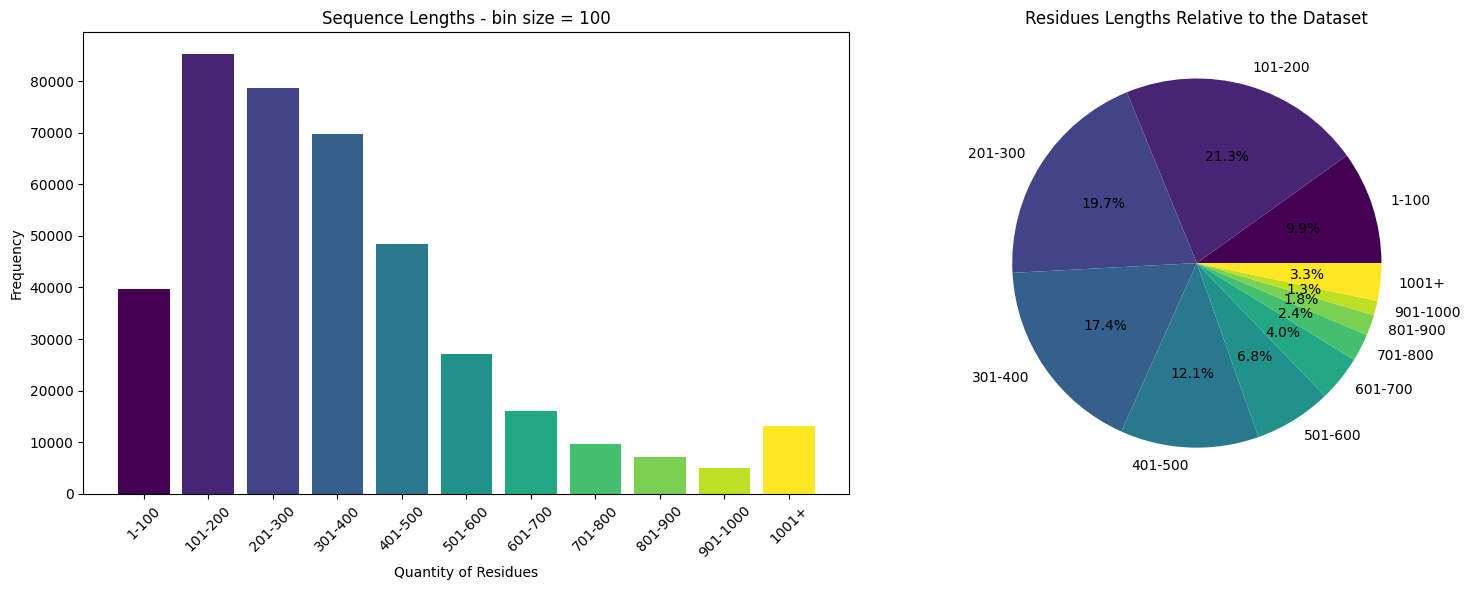

CPU times: user 219 ms, sys: 151 ms, total: 370 ms
Wall time: 195 ms


In [5]:
%%time
# Define the bin function
def bin_data(s, start, end, step):
    # Create the bins
    bins = list(range(start, end+1, step)) + [np.inf]

    # Create the labels
    labels = [f'{i+1}-{i+step}' for i in range(start, end, step)] + ['1001+']
    
    # Cut the Series
    s_cut = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=False)
    
    return s_cut

# we'll work with the sequences and their lengths
s = train.sequence_length.to_numpy()

# Bin the data
s_binned = bin_data(s, start=0, end=1000, step=100)

# Count the frequency of each bin
s_counts = s_binned.value_counts()

# Generate colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(s_counts)))

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Create the bar plot on the first subplot
axs[0].bar(s_counts.index, s_counts.values, color=colors)
axs[0].set_title('Sequence Lengths - bin size = 100')
axs[0].set_xlabel('Quantity of Residues')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Create the pie chart on the second subplot
axs[1].pie(s_counts.values, labels=s_counts.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Residues Lengths Relative to the Dataset')

# Display the plots
plt.tight_layout()
plt.show()

### ESM-2nv limits 
The current limit for ESM-2nv is 1023 Residues based on the nemo checkpoints, so we will have to decrease the dataset accordingly.

### Data Cleaning

We can also ignore the test and validation sets for this example (since we're not training a model). 
 
In this example, we will use two groups of proteins:

1. Up to 100 amino acids, which can include functional types such as 

 - **Regulatory Peptides**: For example, Insulin, with 51 amino acids.

 - **Neuropeptides**: Small protein-like molecules used by neurons to communicate with each other. Substance P, a neuropeptide involved in pain perception, contains 11 amino acids.

 - **Antimicrobial Peptides**: These are an essential part of the innate immune response and have antibiotic properties. An example is defensins, which typically contain 18-45 amino acids.

 - **Toxins**: Many toxins produced by plants, animals, and bacteria are small peptides. For example, Melittin, the main toxin in bee venom, has 26 amino acids.

 - **Cytokines**: Some small cytokines, often referred to as chemokines, have less than 100 amino acids. An example is Interleukin-8 (IL-8), a chemokine produced by macrophages, with 99 amino acids.


2. Between 400 and 1000 amino acids, with functional types such as

    - **G-Protein Coupled Receptors (GPCRs)**: This is a large family of proteins that span the cell membrane and receive signals from outside the cell. GPCRs are involved in a vast number of physiological processes and they typically have around 350-1000 amino acids.

    - **Ion Channels**: Ion channels are a class of proteins that allow ions to pass through the membrane in response to a signal. The length of these proteins varies. Some are within the 400-1000 amino acid range, while others are up to 4,000 amino acids.

    - **Cytochrome P450 Enzymes**: These enzymes are involved in the metabolism of various molecules and chemicals within cells. They are typically around 400-500 amino acids long.

    - **Serine/Threonine Protein Kinases**: This is a large family of enzymes that catalyze the addition of a phosphate group to serine or threonine residues in other proteins. While the length varies significantly, many members of this family are within the 1,000 amino acid range.

    - **GTPases**: These are a family of hydrolase enzymes that can bind and hydrolyze guanosine triphosphate (GTP). The proteins are critical regulators of a wide variety of cellular processes. Smaller GTPase proteins are 400-500 amino acids in length, with larger GTPases having lengths around 800 amino acids.

In [6]:
%%time
train = train[(train.sequence_length < 100) | ((train.sequence_length > 400) &  (train.sequence_length < 1000))]
print("Max seq. lentgh (train)", train.sequence_length.max())
print("Length of dataset", len(train))

Max seq. lentgh (train) 999
Length of dataset 152753
CPU times: user 15.3 ms, sys: 2.41 ms, total: 17.7 ms
Wall time: 16.5 ms


In [7]:
train.head()

,record_id,record_name,sequence_length,sequence
12,308364,sp|B1XAK9|PEPQ_ECODH,443,MESLASLYKNHIATLQERTRDALARFKLDALLIHSGELFNVFLDDH...
14,21258,sp|B7NHG9|ARAB_ECO7I,566,MAIAIGLDFGSDSVRALAVDCATGEEIATSVEWYPRWQKGQFCDAP...
17,167195,sp|A0Q2A8|GSA_CLONN,433,MKELKHTKSEAMFKEAVKYIPGGVNSPVRAFGSVGLNPIFIDRAKG...
21,305568,sp|Q5R6T1|PDIA6_PONAB,440,MALLVLGLVSCAFFLEVNGLYSSSDDVIELTPSNFNREVIQSDSLW...
22,230949,sp|O08843|LST1_MOUSE,95,MSDDNGSGNNCTTNHFLLYGSLGLGGLLLLLVIILFICLCGFSQRV...


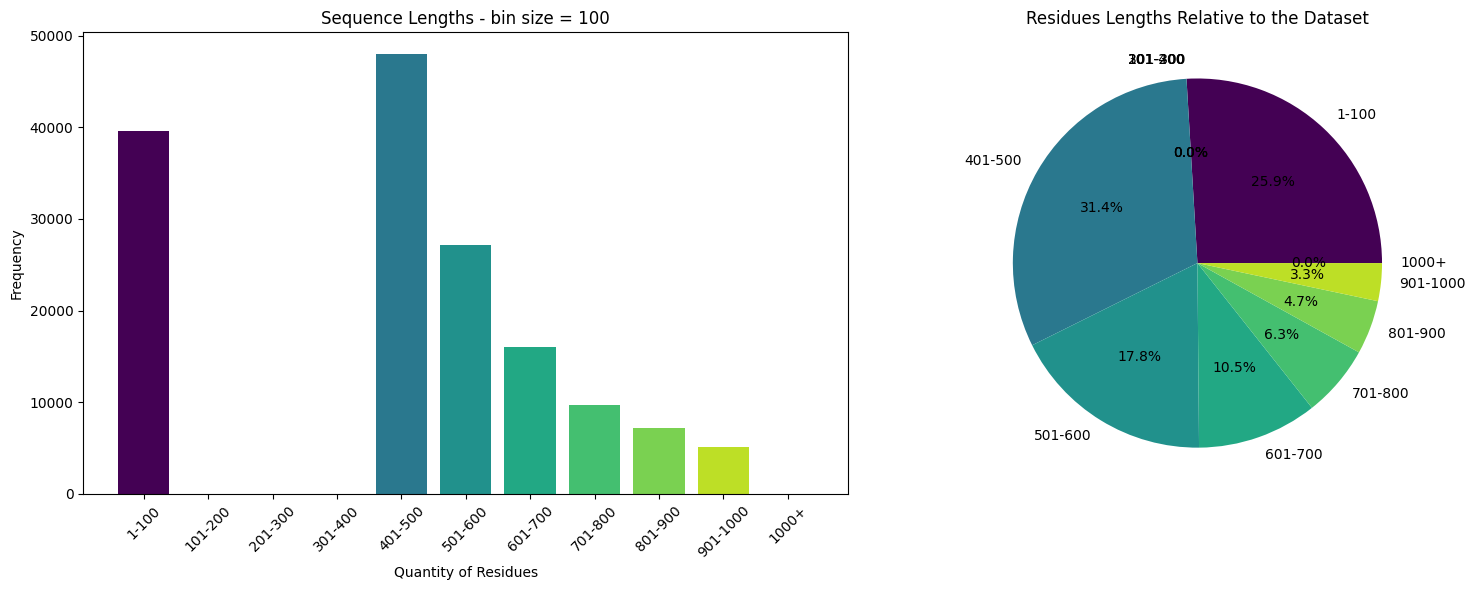

CPU times: user 193 ms, sys: 153 ms, total: 346 ms
Wall time: 177 ms


In [8]:
%%time
# Define the bin function
def bin_data(s, start, end, step):
    # Create the bins
    bins = list(range(start, end+1, step)) + [np.inf]

    # Create the labels
    labels = [f'{i+1}-{i+step}' for i in range(start, end, step)] + ['1000+']
    
    # Cut the Series
    s_cut = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=False)
    
    return s_cut

# we'll work with the sequences and their lengths
s = train.sequence_length.to_numpy()

# Bin the data
s_binned = bin_data(s, start=0, end=1000, step=100)

# Count the frequency of each bin
s_counts = s_binned.value_counts()

# Generate colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(s_counts)))

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Create the bar plot on the first subplot
axs[0].bar(s_counts.index, s_counts.values, color=colors)
axs[0].set_title('Sequence Lengths - bin size = 100')
axs[0].set_xlabel('Quantity of Residues')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Create the pie chart on the second subplot
axs[1].pie(s_counts.values, labels=s_counts.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Residues Lengths Relative to the Dataset')

# Display the plots
plt.tight_layout()
plt.show()

**Using the Inference Wrapper**  

We will obtain the embeddings for the desired sequences based on the pre-trained models we have previously downloaded. 

To avoid memory issues, we'll submit sequences individually. 

In this exampe we are creating a embeddings vectors to be clustered. We know the vector's dimension by ESM-2nv models specifications. 

**Defines a Scaling Function**

In [9]:
%%time
# Initalize the Inference Wrapper that will invoke the pre-trained model
esm = ESMInferenceWrapper()

# Defines the number of samples per amino acid group
samples = 500
# Set the hidden dim for ESM2nv-650M model
hidden_dim = 1280

# Creates a balanced dataset
indexes_100 = np.random.choice(len(train[train.sequence_length < 100]),samples,replace=False)
indexes_400 = np.random.choice(len(train[train.sequence_length > 400]),samples,replace=False)
balanced_samples = [*indexes_100, *indexes_400]

# Initializes an embeddings tensor
prot_embeddings = torch.empty(len(balanced_samples), hidden_dim, dtype=torch.float32).cuda()

# Build the embeddings tensor based on mean pooling
for _, i in enumerate(balanced_samples):
    # Obtain embeddings. 
    embeddings = esm.seq_to_embedding(train.sequence.to_arrow().to_pylist()[i])
    prot_embeddings[_,:] = embeddings.mean(dim=0)

CPU times: user 2min 26s, sys: 37.9 s, total: 3min 4s
Wall time: 4min 59s


In [10]:
# Auxiliary matrix shape (to be used in clustering) must be (2 x samples, 1280)
prot_embeddings.shape

torch.Size([1000, 1280])

**DBSCAN**

Script extracted from RAPIDS API tutorial.

More information available at: https://docs.rapids.ai/api/cuml/stable/api/#clustering

Num. Of Clusters:  2


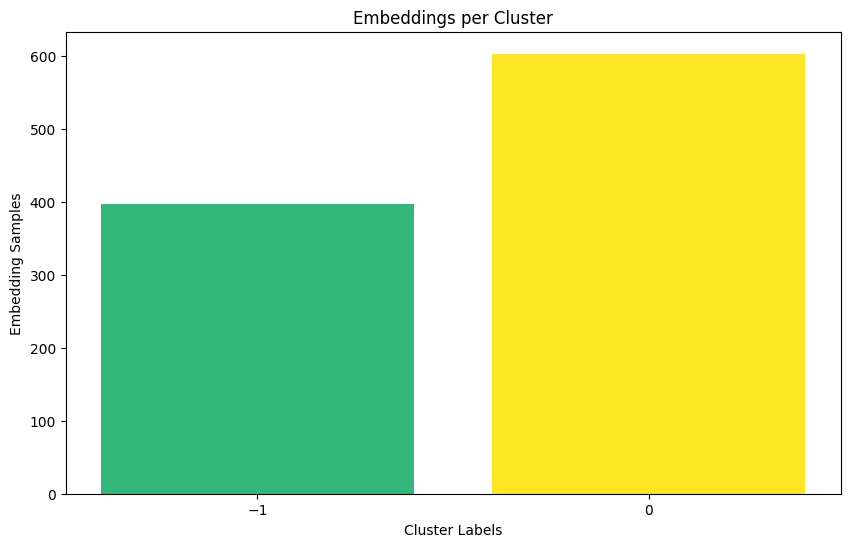

CPU times: user 56.7 ms, sys: 100 ms, total: 157 ms
Wall time: 66.3 ms


In [13]:
%%time
ary = cp.asarray(prot_embeddings)
prev_output_type = cuml.global_settings.output_type
cuml.set_global_output_type('cudf')
dbscan_float = cuml.DBSCAN(eps=.35, min_samples=100)
dbscan_float.fit(ary)
cuml.set_global_output_type(prev_output_type)
print("Num. Of Clusters: ", dbscan_float.labels_.nunique())

import matplotlib.ticker as ticker
labels = dbscan_float.labels_.values.get()

# Count the number of samples in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color=plt.cm.viridis(counts / float(max(counts))))
plt.xlabel('Cluster Labels')
plt.ylabel('Embedding Samples')
plt.title('Embeddings per Cluster')

# Ensure all labels are displayed on x-axis and they are integers
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xticks(unique_labels)

plt.show()

Using T-SNE to reduce dimensionality so that we can visualize the clusters of data

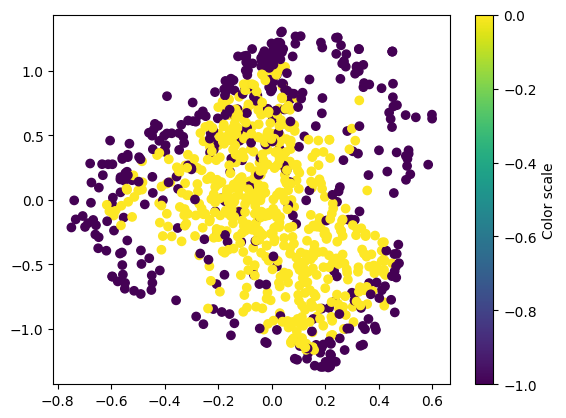

CPU times: user 391 ms, sys: 144 ms, total: 535 ms
Wall time: 377 ms


In [20]:
%%time
# Hyperparameters picked arbitrarily for this example
tsne = cumlTSNE(n_components=2, perplexity=8, learning_rate=300, random_state=42)
tsne_embedding = cudf.DataFrame(tsne.fit_transform(ary))

# Create scatterplot
colors = dbscan_float.labels_.values.get()
plt.scatter(tsne_embedding.iloc[:,0].to_numpy(), tsne_embedding.iloc[:,1].to_numpy(), c=colors)
# Add a colorbar
plt.colorbar(label='Color scale')
# Show plot
plt.show()

The plot above is for the sake of exemplification based on a subset of random proteins and should not be representative of a full application.

# Conclusion

In this example, you saw how simple it is to operate with BioNeMo and integrate it with classic clustering and dataframe manipulation activities.